In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns, load_run, extract_best_entries
from IPython.display import display, Image as IPImage

In [25]:
load_existing_run = None

if load_existing_run is None:
    num_cats = 10
    entries_per_cat = 1000
    image_gen_params = {
        'magnification': 1,
        'resolution': 32,
        'invert_color': True,
        'stroke_width_scale': 1
    }
    
    # files = get_dataset_files()
    # files = random.sample(files, num_cats)
    names = ['ambulance', 'castle', 'coffee cup', 'fish', 'power outlet', 'hammer', 'snowman', 'helicopter', 'fan', 'star']
    # names = ['ambulance','bed','bench','bread','castle','cell phone','chair','church','coffee cup','crown','cruise ship','cup','dishwasher','dresser','eye','face',
        # 'fan','fire hydrant','fish','hammer','hat','helicopter','ice cream','lantern','passport','pickup truck','pillow','power outlet','sailboat','sandwich','snowman','star',
        # 'strawberry','suitcase','table','telephone','traffic light','watermelon','wine glass']
    files = list(map(lambda n: f"./dataset/{n}.ndjson", names))
    df = extract_best_entries(files, entries_per_cat, recognized=True, skip_first=200)
    
    print(f'Loaded {len(df)} entries from {files}')
    df = df.sample(len(df))
    print('Done shuffling dataset')
    df = generate_pixel_columns(df, **image_gen_params).reset_index(drop=True)
    print('Done generating pixel columns')

else:
    run = load_run(load_existing_run)
    df = run['data']
    num_cats = len(df['word'].value_counts())
    entries_per_cat = df['word'].value_counts()[df['word'].value_counts().keys()[0]]
    image_gen_params = run['img_params']
    

Loaded 10000 entries from ['./dataset/ambulance.ndjson', './dataset/castle.ndjson', './dataset/coffee cup.ndjson', './dataset/fish.ndjson', './dataset/power outlet.ndjson', './dataset/hammer.ndjson', './dataset/snowman.ndjson', './dataset/helicopter.ndjson', './dataset/fan.ndjson', './dataset/star.ndjson']
Done shuffling dataset
Done generating pixel columns


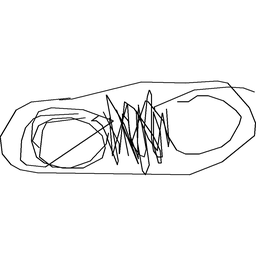

bandage


In [10]:
img = df.sample().iloc[0]
display(IPImage(render_single(img['drawing'])))
print(img['word'])

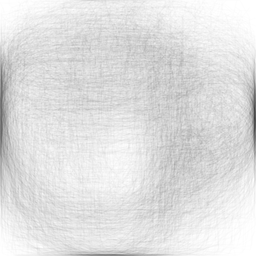

1000 superimposed coffee cups.


In [30]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df['word'].values)
imgs = df[df['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [26]:
train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Train: 9000 entries, test: 1000 entries.


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True

y = train['word'].to_numpy()
X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
print("Done generating features and target")

if pca_on:
    if load_existing_run is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(.85)
        X = pca.fit_transform(X)
        print(f'PCA & standardization done. Keeping {pca.n_components_} features')
    else:
        scaler = run['scaler']
        pca = run['pca']
        X = scaler.transform(X)
        X = pca.transform(X)
        print('Applied scaler and PCA.')

save_to_disk = True

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    with open(folder + 'img_params', 'w') as f:
        f.writelines(str(image_gen_params))
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(scaler, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

Done generating features and target
PCA & standardization done. Keeping 556 features
Done saving dataset to disk
Done saving PCA and scaler to disk


In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from itertools import repeat

# Which class does this instance belong to?
# in a multiclass classification problem can be reduced to:
#  for each class in classes:
#    does this instance belong to class? -> probability
#  return the class with the highest probability

classifiers = {
    # 'LinearSVC': LinearSVC(dual=False),
    'NuSVC': NuSVC(nu=.01),
    # 'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1),
    'SVC': SVC(kernel='rbf', C=2.5, gamma=.0001105),
    # 'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(store_covariance=True),
    # 'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(store_covariance=True),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=tuple(repeat(int(pca.n_components_ * 1.2), 3)), solver='lbfgs', alpha=1e-07),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'ExtraTreeClassifier': ExtraTreeClassifier(),
    'KernelRidge': KernelRidge(),
    # 'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0)),
}

models = {}
start = time.time()
for type, classifier in classifiers.items():
    models[type] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    end = time.time()
    print(f"Done training {type} model in {'{:.2f}'.format(end - start)}s")
    start = end

if save_to_disk:
    joblib.dump(models, folder + 'models')
    print("Done saving models to disk")

Done training NuSVC model in 44.01s
Done training SVC model in 27.35s
Done training MLPClassifier model in 100.17s
Done training KernelRidge model in 18.01s
Done saving models to disk


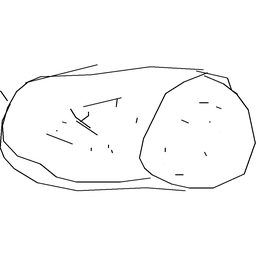

Using SVC classifier
ambulance(predicted) == bread(actual) ? False


In [17]:
import random
cls_type, model = random.choice(list(models.items()))
# model = models['SVC']

sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(f"Using {cls_type} classifier")
print(f"{prediction[0]}(predicted) == {sample['word'].iloc[0]}(actual) ? {sample['word'].iloc[0] == prediction[0]}")

In [29]:
for model_type, model in models.items():
    test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    if pca_on:
        test2 = scaler.transform(test2)
        test2 = pca.transform(test2)
    prediction = model.predict(test2)

    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(test['word'].values.tolist(), prediction)
    print(f"{model_type} classifier, accuracy: {acc_score}")

NuSVC classifier, accuracy: 0.824
SVC classifier, accuracy: 0.726
MLPClassifier classifier, accuracy: 0.784
KernelRidge classifier, accuracy: 0.678


LinearSVC classifier, accuracy: 0.9208

NuSVC classifier, accuracy: 0.9756

SVC classifier, accuracy: 0.9696

LinearDiscriminantAnalysis classifier, accuracy: 0.902

QuadraticDiscriminantAnalysis classifier, accuracy: 0.9332

MLPClassifier classifier, accuracy: 0.9708

KernelRidge classifier, accuracy: 0.9036